# Germeval 2019 Classification

https://projects.fzai.h-da.de/iggsa/data-2019/

https://www.researchgate.net/publication/337007402_UPB_at_GermEval-2019_Task_2_BERT-Based_Offensive_Language_Classification_of_German_Tweets

In [2]:
from fastai.text.all import *

In [3]:
lang = 'de'
backwards = False
bs=128
vocab_sz = 15000
num_workers=18
step = 'class' # fine-tuning

In [4]:
direction = 'fwd' if backwards == False else 'bwd'

In [5]:
wiki = f'{lang}wiki'
base_path = Path('data')
path = base_path/wiki
model_base_path = path/'model'
model_path = model_base_path/step/direction
spm_path = model_base_path/'ft'/'spm'
lm_fns = [(model_base_path/'ft'/direction/f'{lang}_ft').absolute(), 
          (model_base_path/'ft'/direction/f'{lang}_ft_vocab').absolute()]

In [6]:
data_path = path/'germeval'

In [7]:
lm_fns, spm_path

([Path('/data/projects/git/fastai_ulmfit_german/data/dewiki/model/ft/fwd/de_ft'),
  Path('/data/projects/git/fastai_ulmfit_german/data/dewiki/model/ft/fwd/de_ft_vocab')],
 Path('data/dewiki/model/ft/spm'))

## Prepare classifier dataset

In [8]:
df = pd.read_csv(data_path/'data_classification.csv')

In [14]:
df

,text,label,label_fine,is_valid
0,Komisch das die Realitätsverweigerung immer von linken erbärmlichen Correctiv Accounts ausgeht...,OFFENSE,INSULT,True
1,"CDU steht seid Strauss, Kohl, Schäuble, vdLeyen für Korruption, Schwarzgeld, und dies überall...",OFFENSE,ABUSE,True
2,"Die Gesichter, Namen, Religion der Täter würde zur Aufklärung beitragen...",OTHER,OTHER,True
3,"Wie verwirrt muss man sein um sich zu weigern die Tatsachen anzuerkennen, das dieser Hass von Ferkel importiert wurde....was bezweckt man damit sich selber so zu belügen, unverständlich",OFFENSE,ABUSE,True
4,"Weil die AfD den Ferkelfunk abschaffen will, deshalb haben die Linken Zecken, Schmarotzer Angst für ihr kacken arbeiten zu müssen, deshalb sind die Führer treu und senden jeden Dreck, Lüge...",OFFENSE,ABUSE,True
...,...,...,...,...
15413,"250 Menschen auf der Demonstration gegen das Dublin 2 Abkommen auf der Demo der selbstorganisierten ,,Refugees for Change'' #Refugeeswelcome",OTHER,OTHER,False
15414,Erneut Massaker an Kurdische ZivilistInnen durch islamistische ISIS. YXK ruft bundesweit zu Demonstrationen auf. #Rojava #ISIS #syrien,OTHER,OTHER,False
15415,Hunderte Refugees haben die Grenze zur spanischen Exklave Melilla überwunden. Freedom of Movement is everybodies right! #Rassismus #NoBorder,OTHER,OTHER,False
15416,"Heute ab 17:00 Uhr an der Alten Oper FFM: Kundgebung/Picknick/Musik zum Jahrestag der Gezi-Proteste #Gezi, #Taksim, #Solidarität, #Erdogan",OTHER,OTHER,False


## Train model

In [10]:
tok = SentencePieceTokenizer(lang=lang, sp_model=spm_path/'spm.model')

In [11]:
with open(f'{lm_fns[1]}.pkl', 'rb') as f:
      vocab = pickle.load(f)

In [12]:
dblocks = DataBlock(blocks=(TextBlock.from_df('text', tok=tok, vocab=vocab, backwards=backwards), CategoryBlock),
                    get_x=ColReader('text'),
                    get_y=ColReader('label'), 
                    splitter=ColSplitter())
dls = dblocks.dataloaders(df, bs=bs, num_workers=num_workers)

/home/florian/miniconda3/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
dls.show_batch()

,text,category
0,"▁xxbos ▁xxmaj ▁als ▁xxmaj ▁waffen lie fer ant ▁xxmaj ▁israel s ▁be geht ▁xxmaj ▁deutschland ▁xxmaj ▁ verrat ▁an ▁menschen - ▁und ▁völkerrecht lichen ▁xxmaj ▁grund prinzip ien . ▁xxmaj ▁es ▁ist ▁para do x , ▁dass ▁xxmaj ▁deutschland ▁zur ▁xxmaj ▁rechtfertigung ▁seiner ▁kriminellen ▁xxmaj ▁politik ▁auf ▁den ▁xxmaj ▁holocaust ▁verweis t .” ▁( zi t iert ▁aus : ▁xxmaj ▁möge ▁keiner ▁sagen , ▁ er ▁hätte ▁es ▁nicht ▁gewusst !) ▁xxup ▁other ▁xxup ▁other ▁xxmaj ▁im ▁xxmaj ▁jahr ▁2 ▁xxrep ▁3 ▁0 ▁ er schi en ▁das ▁xxmaj ▁buch : ▁» die ▁holocaust - industrie « ▁von ▁xxmaj ▁prof . ▁xxmaj ▁fin kel stein . ▁xxmaj ▁und ▁2010 ▁dann , ▁ nan u , ▁wen ▁wundert ‘ s : ▁40 . ▁xxrep ▁3 ▁0 ▁ . ▁xxrep ▁3 ▁0 ▁us - do ll ar ▁xxmaj ▁ betrug ▁der ▁xxmaj ▁jewish ▁xxmaj ▁claim ▁xxmaj ▁ conference ▁wird ▁bekannt . ▁xxup",OFFENSE
1,▁xxbos ▁ : ▁xxmaj ▁merkel ▁ bricht ▁gelten des ▁xxmaj ▁gesetz ▁ - ▁und ▁xxmaj ▁kirche ▁spendet ▁xxmaj ▁bei fall ▁| lbr | ▁xxup ▁der ▁xxup ▁ abschaum ! ▁xxup ▁offense ▁xxup ▁abuse ▁xxmaj ▁vor ▁allem : ▁xxmaj ▁was ▁hat ▁ein ▁deutsche s ▁xxmaj ▁anti dis krimi ner ungs gesetz ▁mit ▁israelische n ▁xxmaj ▁staatsbürger n ▁zu ▁tun ? ▁xxup ▁other ▁xxup ▁other ▁xxmaj ▁zum ▁xxmaj ▁beispiel . ▁xxmaj ▁ein ▁anderes ▁wäre : ▁xxmaj ▁witz e ▁über ▁xxmaj ▁minderheiten . ▁xxmaj ▁es ▁ist ▁ein ▁perfekte s ▁xxmaj ▁ein falls tor ▁für ▁den ▁xxmaj ▁opfer kult . ▁xxup ▁offense ▁xxup ▁insult ▁xxmaj ▁frauen ▁haben ▁bereits ▁zwei ▁xxmaj ▁tage ▁lang ▁niemanden ▁mehr ▁der ▁sexuelle n ▁xxmaj ▁belästigung ▁be zi chtig t . ▁| lbr | ▁xxmaj ▁was ▁ist ▁da ▁los ? ▁xxmaj ▁gibt ▁es ▁xxmaj ▁ schuhe ▁und ▁xxmaj ▁hand tasche n ▁im ▁xxmaj ▁sonder angebot ? ▁| lbr | ▁# ▁metoo,OTHER
2,"▁xxbos ▁xxmaj ▁wir ▁nehmen ▁richtig ▁viel ▁xxmaj ▁rücken wind ▁mit ▁aus ▁dem ▁# ▁xxmaj ▁ reform ations jubiläum . ▁xxmaj ▁das ▁wird ▁die ▁xxmaj ▁zukunft ▁ prä gen .“ ▁ - ▁xxup ▁ ek d - r v ▁be d ford - s tro hm ▁xxup ▁other ▁xxup ▁other ▁xxmaj ▁welche ▁xxmaj ▁rechte ▁vom ▁xxmaj ▁muslim en ▁sind ▁denn ▁in ▁xxmaj ▁europa ▁in ▁xxmaj ▁gefahr ? ▁xxup ▁other ▁xxup ▁other ▁xxmaj ▁im ▁xxmaj ▁koran ▁steht ▁zwar , ▁dass ▁xxmaj ▁moslems ▁xxmaj ▁ungläubige ▁töten ▁sollen , ▁aber ▁das ▁hat ▁nichts ▁damit ▁zu ▁tun , ▁wenn ▁xxmaj ▁moslems ▁xxmaj ▁ungläubige ▁töten . ▁xxup ▁offense ▁xxup ▁abuse ▁xxmaj ▁die ▁xxmaj ▁juden ▁in ▁xxmaj ▁deutschland ▁waren ▁xxmaj ▁deutsche ▁und ▁keine ▁xxmaj ▁anderen . ▁xxmaj ▁deutsche ▁und ▁xxmaj ▁juden ▁zum ▁xxmaj ▁gegensatz pa ar ▁zu ▁machen ▁ist ▁v öl k isch ▁und ▁antisemitisch . ▁xxmaj ▁juden ▁und ▁xxmaj ▁deutsche ▁sind ▁xxmaj ▁identität en ▁mit ▁xxmaj",OTHER
3,"▁xxbos ▁ : ▁xxmaj ▁ich ▁denke , ▁| lbr | ▁wir ▁sind ▁alle ▁noch ▁zu ▁ träg e ▁und ▁| lbr | ▁wahrscheinlich ▁auch ▁noch ▁zu ▁feige . ▁| lbr | ▁xxup ▁steh ▁xxup ▁auf ▁xxup ▁und ▁xxup ▁ kämpf e ! ▁xxup ▁other ▁xxup ▁other ▁xxmaj ▁wir ▁beenden ▁den ▁xxmaj ▁livestream ▁zum ▁# ▁xxmaj ▁friedens licht ▁mit ▁einem ▁xxmaj ▁seg en ▁von ▁xxmaj ▁pat er ▁xxmaj ▁philipp ▁aus ▁xxmaj ▁maria ▁xxmaj ▁la ach . ▁# ▁ein tag im advent ▁xxup ▁other ▁xxup ▁other ▁xxmaj ▁bis ▁~ 19 60 ▁war ▁die ▁xxmaj ▁welt ▁in ▁xxmaj ▁deutschland ▁noch ▁ein iger maßen ▁in ▁xxmaj ▁ordnung . ▁xxmaj ▁werte , ▁xxmaj ▁tradition , ▁xxmaj ▁politik , ▁xxmaj ▁kirche . ▁xxup ▁other ▁xxup ▁other ▁xxmaj ▁genau ▁deshalb ▁wähle ▁immer ▁xxup ▁npd ▁statt ▁euch ▁xxmaj ▁ weich e ier ! ▁xxup ▁offense ▁xxup ▁insult ▁| lbr | ▁xxmaj ▁schalt ▁den ▁xxmaj ▁ e le tro",OTHER
4,"▁xxbos ▁xxmaj ▁achtung ▁xxmaj ▁ e il meldung ▁xxrep ▁3 ▁ ! ▁| lbr | ▁xxmaj ▁what s ▁xxmaj ▁app ▁ s chränkt ▁xxmaj ▁informations freiheit ▁ein , ▁es ▁ist ▁nicht ▁mehr ▁möglich ▁xxmaj ▁nachrichten ▁an ▁mehr ▁als ▁5 ▁xxmaj ▁ user ▁zu ▁senden . ▁– ▁xxmaj ▁das ▁sind ▁xxmaj ▁ maßnahmen ▁wie ▁in ▁xxmaj ▁indien , ▁xxmaj ▁china , ▁xxmaj ▁nord korea ▁usw . ▁xxmaj ▁gratulation , ▁wir ▁haben ▁dieses ▁xxmaj ▁niveau ▁endlich ▁erreicht . ▁< u + ▁xxrep ▁3 ▁0 ▁1 f 44 f > < u + ▁xxrep ▁3 ▁0 ▁1 f 44 f > < u + ▁xxrep ▁3 ▁0 ▁1 f 44 f > < u + ▁xxrep ▁3 ▁0 ▁1 f 44 f > < u + ▁xxrep ▁3 ▁0 ▁1 f 44 f > < u + ▁xxrep ▁3 ▁0 ▁1 f

In [13]:
dls.vocab[1]

['OFFENSE', 'OTHER']

In [14]:
len(dls.train), len(dls.valid)

(96, 24)

In [15]:
avg = 'macro'
metrics=[accuracy, Precision(average=avg), Recall(average=avg), F1Score(average=avg)]

In [21]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=1, pretrained=False, 
                               metrics=metrics).to_fp16()
learn.path = model_path

In [22]:
learn.load_encoder(f'{lm_fns[0].absolute()}_encoder')

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=1.0964781722577754e-06)

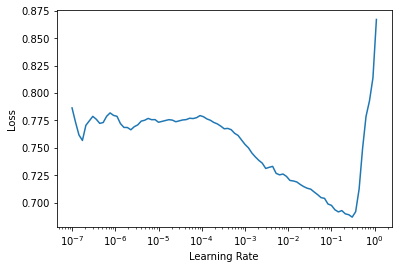

In [23]:
learn.lr_find()

In [24]:
lr = 3e-2
lr *= bs/48
lr

0.07999999999999999

In [25]:
learn.fine_tune(8, lr)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.579711,0.525198,0.730452,0.698462,0.627436,0.634666,00:04


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.509739,0.523126,0.746288,0.760170,0.625437,0.629847,00:06
1,0.471208,0.499858,0.759155,0.770299,0.648269,0.659285,00:06
2,0.449709,0.501509,0.786539,0.767928,0.716702,0.731732,00:06
3,0.418851,0.520277,0.768393,0.735638,0.746471,0.740167,00:06
4,0.382857,0.450454,0.796107,0.768326,0.751296,0.758432,00:06
5,0.349603,0.480849,0.791818,0.763256,0.745687,0.752968,00:06
6,0.314310,0.496736,0.795777,0.767801,0.751327,0.758264,00:06
7,0.302000,0.517614,0.790828,0.760339,0.752599,0.756151,00:06


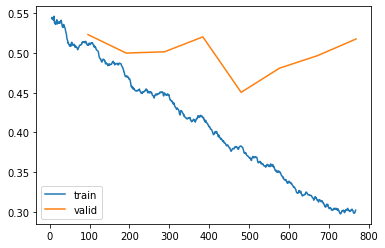

In [26]:
learn.recorder.plot_loss()

In [22]:
learn.export()